Need to explain some of the reasons why estimating overpayment is very difficult:

* Mining pools incur opportunity cost to pay out their members (e.g. with 1 gwei transactions)
* Some users are bidding for inclusion only, some are bidding to be included at the front of the block
* Flashbots means that bundles of transactions may be included at an apparent opportunity cost
* Block timing is random, so supply of gas is very variable
* the ways in which the blockchain is used change rapidly and constantly - NFT mint events, airdrops, liquidity mining programmes come and go, so that the set of transactions under consideration may be different over the course of a day

So we want to look at smart contract interactions where we have some idea of the intent!
* Tornado Cash deposits
* Chainlink https://etherscan.io/address/0x37bc7498f4ff12c19678ee8fe19d713b87f6a9e6
* Optimism gateway: https://etherscan.io/address/0x99c9fc46f92e8a1c0dec1b1747d010903e884be1
* Synthetix?
* Layer 2s?

Can we find out how people are misusing 1559 (e.g. type 2 transactions with maxfee=priority fee)

Explore the failure of "low ball" transactions:
* note tweets by evan_van_ness (https://twitter.com/evan_van_ness/status/1446207826326695936?s=20) and Lefteris
* can I recreate the occasional tx pool clearing behaivour using Barnabe's simulation?

Also look at failure rate of timed transactions (like uniswap trades) as tweeted by Hayden

Blocknative [analysis of the impact of 1559](https://www.blocknative.com/blog/eip-1559-adoption)

Incorporate [Trent Van Epps analysis](https://dune.xyz/trent/Priority-Fee-Overpayment)

Also coinbase's [successes of 1559](https://blog.coinbase.com/the-technical-benefits-of-eip-1559-c41bb85f5924)

In [1]:
# imports and constants

import requests
import time
from jsonrpcclient import request
import json
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from datetime import datetime, timedelta
from scipy.stats import poisson
import math
import numpy as np
import pandas as pd

ERIGON_URL = "http://192.168.1.104:8545/"
START_BLOCKNUM = 12550000
LONDON_BLOCKNUM = 12965000
END_BLOCKNUM = 13520000

In [2]:
# get sample data directly from Erigon node

start = time.time()
blocks = []
for blocknum in range(START_BLOCKNUM, END_BLOCKNUM):
    batch = [
        request("eth_getBlockByNumber", [blocknum, True]),
        request("eth_getBlockReceipts", [blocknum])
    ]
    response = requests.post(ERIGON_URL, json=batch)
    block_info = response.json()[0]['result']
    transactions = block_info['transactions']
    receipts = response.json()[1]['result']
    if len(transactions) > 0:
        tmp = sorted(zip(transactions, receipts), key=lambda k: int(k[1]['effectiveGasPrice'], base=16))
        transactions, receipts = zip(*tmp)
    txs_gas_used = []
    txs_fee_cap = []
    txs_priority_fee = []
    txs_gas_price = []
    #txs_index = []
    txs_type = []
    #txs_status = []
    for i, r in enumerate(receipts):
        txs_gas_used += [int(r['gasUsed'], base=16)]
        #txs_index += [int(r['transactionIndex'], base=16)]
        tx_type = int(r['type'], base=16)
        txs_type += [tx_type]
        if tx_type == 2:
            txs_fee_cap += [int(transactions[i]['maxFeePerGas'], base=16)]
            txs_priority_fee += [int(transactions[i]['maxPriorityFeePerGas'], base=16)]
        else:
            txs_fee_cap += [None]
            txs_priority_fee += [None]
        txs_gas_price += [int(r['effectiveGasPrice'], base=16)]
        #txs_status += [int(r['status'], base=16)]
    
    if 'baseFeePerGas' in block_info:
        basefee = int(block_info['baseFeePerGas'], 16)
    else:
        basefee = None
    
    blocks += [{
        'timestamp': int(block_info['timestamp'], base=16),
        'gas_limit': int(block_info['gasLimit'], base=16),
        'gas_used': int(block_info['gasUsed'], base=16),
        'basefee': basefee,
        'txs_gas_used': txs_gas_used,
        'txs_gas_price': txs_gas_price,
        'txs_fee_cap': txs_fee_cap,
        'txs_priority_fee': txs_priority_fee,
        #'txs_index': txs_index, 
        'txs_type': txs_type, 
        #'txs_status': txs_status
    }]
    print(f"{blocknum}, {100 * (blocknum - START_BLOCKNUM) / (END_BLOCKNUM - START_BLOCKNUM):.2f}%", end='\r')

print('\n' + str(timedelta(seconds = time.time() - start)))

13519999, 100.00%
8:12:17.815143


In [3]:
london_timestamp = blocks[LONDON_BLOCKNUM - START_BLOCKNUM]['timestamp']
london_datetime = datetime.utcfromtimestamp(london_timestamp)
print(london_datetime)

2021-08-05 12:33:42


In [4]:
# find out how the transaction types have varied over time. Include type 2 transactions with feescap and priority equal

start_date = datetime.utcfromtimestamp(blocks[0]['timestamp']).date()
end_date = datetime.utcfromtimestamp(blocks[-1]['timestamp']).date()
num_days = (end_date - start_date).days + 1

dates = [start_date + timedelta(days=d) for d in range(num_days)]
legacy_gas = [0] * num_days
legacy_equiv_gas = [0] * num_days
eip_1559_gas = [0] * num_days

for block in blocks:
    date = datetime.utcfromtimestamp(block['timestamp']).date()
    d = (date - start_date).days
    for i in range(len(block['txs_gas_used'])):
        t = block['txs_type'][i]
        g = block['txs_gas_used'][i]
        if t == 0 or t == 1:
            legacy_gas[d] += g
        elif t == 2:
            if block['txs_fee_cap'][i] == block['txs_priority_fee'][i]:
                legacy_equiv_gas[d] += g
            else:
                eip_1559_gas[d] += g
        else:
            print(f"unknown transaction type {t} in block {blocknum}")
    
    #perc = 100 * (blocknum - START_BLOCKNUM) / (END_BLOCKNUM - START_BLOCKNUM)
    #print(f"{perc:.2f}% complete", end='\r')

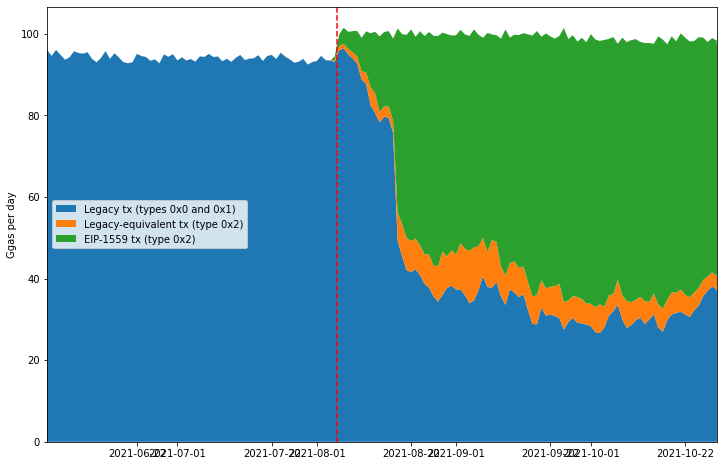

In [5]:
fig, ax = plt.subplots(figsize=(12, 8))
labels = ['Legacy tx (types 0x0 and 0x1)', 'Legacy-equivalent tx (type 0x2)', 'EIP-1559 tx (type 0x2)']
a = [g / 1e9 for g in legacy_gas]
b = [g / 1e9 for g in legacy_equiv_gas]
c = [g / 1e9 for g in eip_1559_gas]
ax.stackplot(dates, a, b, c, labels=labels)
ax.set_xlim(xmin=dates[1], xmax=dates[-2])
ax.set_ylabel('Ggas per day')
ax.axvline(london_datetime, color='r', linestyle='dashed')
ax.legend(loc='center left');

Relative number of blocks per group — bounds for 90% interval

period (s) | lower | upper
--------------------------
        60 |   22% |  179%
       120 |   45% |  157%
       300 |   67% |  135%
       600 |   76% |  126%
      1800 |   86% |  114%
      3600 |   90% |  110%


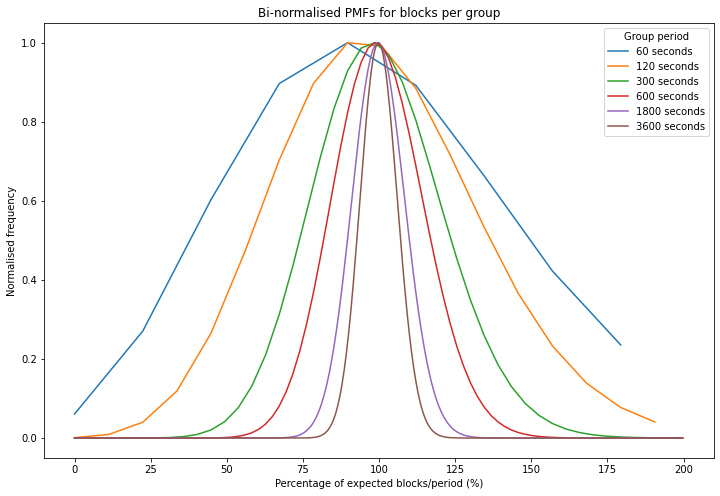

In [6]:
# investigate gas supply variability

sample_time = blocks[-1]['timestamp'] - blocks[0]['timestamp']
block_frequency = len(blocks) / sample_time

print("Relative number of blocks per group — bounds for 90% interval\n")
print("period (s) | lower | upper")
print("--------------------------")
fig, ax = plt.subplots(figsize=(12, 8))
for group_period in [60, 120, 300, 600, 1800, 3600]: # 1 min, 2 mins, 5 mins, 10 mins, 30 mins, 1 hour
    x = []
    pmf = []
    expected_blocks_per_period = block_frequency * group_period
    for i in range(int(expected_blocks_per_period * 2 + 1)):
        x.append(100 * i / expected_blocks_per_period)
        pmf.append(poisson.pmf(i, expected_blocks_per_period))
    
    norm = max(pmf)
    ax.plot(x, [p / norm for p in pmf], label=f"{group_period} seconds")
    interval = poisson.interval(0.9, expected_blocks_per_period)
    lower = 100 * interval[0] / expected_blocks_per_period
    upper = 100 * interval[1] / expected_blocks_per_period
    print(f"{group_period:>10} | {lower:>4.0f}% | {upper:>4.0f}%")

ax.set_title("Bi-normalised PMFs for blocks per group")
ax.set_xlabel("Percentage of expected blocks/period (%)")
ax.set_ylabel("Normalised frequency")
ax.legend(title="Group period");

In [7]:
# get group boundaries (ensure we divide blocks cleanly into pre- and post-London)
group_period = 300 # 5 minutes

num_pre_london_periods = math.ceil((london_timestamp - blocks[0]['timestamp']) / group_period)
first_group = london_timestamp - num_pre_london_periods * group_period

pos = 0
group_start_times = []
group_price_deciles_legacy = []
group_price_deciles_type2 = []
group_price_quartiles_legacy = []
group_price_quartiles_type2 = []
group_start_blocknums = []
group_mean_basefees = []
group_block_counts = []
run_start_time = time.time()
last_update = 0
for start_ts in range(first_group, blocks[-1]['timestamp'], group_period):
    group_start_times += [datetime.utcfromtimestamp(start_ts)]
    group_start_blocknums += [pos + START_BLOCKNUM]
    group_tx_gas_used = []
    group_tx_gas_price = []
    group_tx_type = []
    group_sum_basefee = 0
    group_num_blocks = 0
    while pos < len(blocks) and blocks[pos]['timestamp'] < start_ts + group_period:
        group_tx_gas_used += blocks[pos]['txs_gas_used']
        group_tx_gas_price += blocks[pos]['txs_gas_price']
        group_tx_type += blocks[pos]['txs_type']
        group_num_blocks += 1
        if blocks[pos]['basefee'] is not None:
            group_sum_basefee += blocks[pos]['basefee']
        pos += 1
    
    group_block_counts += [group_num_blocks]
    if group_sum_basefee > 0:
        group_mean_basefees += [group_sum_basefee / (group_num_blocks * 1e9)]
    else:
        group_mean_basefees += [None]
    
    tuples = zip(*sorted(zip(group_tx_gas_price, group_tx_gas_used, group_tx_type)))
    group_tx_gas_price, group_tx_gas_used, group_tx_type = [list(t) for t in tuples]
    
    group_total_gas = sum(group_tx_gas_used)
    group_total_type2_gas = sum(g for i, g in enumerate(group_tx_gas_used) if group_tx_type[i] == 2)
    group_total_legacy_gas = group_total_gas - group_total_type2_gas
    cumulative_legacy_gas = 0
    cumulative_type2_gas = 0
    legacy_deciles = [None] * 9
    type2_deciles = [None] * 9
    for i, g in enumerate(group_tx_gas_used):
        if group_tx_type[i] == 2:
            cumulative_type2_gas += g
            for j, d in enumerate(type2_deciles):
                if d is None and cumulative_type2_gas >= group_total_type2_gas * (j + 1) / 10:
                    type2_deciles[j] = group_tx_gas_price[i] / 1e9
        else:
            cumulative_legacy_gas += g
            for j, d in enumerate(legacy_deciles):
                if d is None and cumulative_legacy_gas >= group_total_legacy_gas * (j + 1) / 10:
                    legacy_deciles[j] = group_tx_gas_price[i] / 1e9
    
    group_price_deciles_legacy += [legacy_deciles]
    group_price_deciles_type2 += [type2_deciles]               
                    
    cumulative_legacy_gas = 0
    cumulative_type2_gas = 0
    legacy_quartiles = [None] * 9
    type2_quartiles = [None] * 9
    for i, g in enumerate(group_tx_gas_used):
        if group_tx_type[i] == 2:
            cumulative_type2_gas += g
            for j, d in enumerate(type2_quartiles):
                if d is None and cumulative_type2_gas >= group_total_type2_gas * (j + 1) / 4:
                    type2_quartiles[j] = group_tx_gas_price[i] / 1e9
        else:
            cumulative_legacy_gas += g
            for j, d in enumerate(legacy_quartiles):
                if d is None and cumulative_legacy_gas >= group_total_legacy_gas * (j + 1) / 4:
                    legacy_quartiles[j] = group_tx_gas_price[i] / 1e9
        
    group_price_quartiles_legacy += [legacy_quartiles]
    group_price_quartiles_type2 += [type2_quartiles]
    
    current_time = time.time()
    if current_time - last_update > 0.1:
        last_update = current_time
        frac = (start_ts - first_group) / (blocks[-1]['timestamp'] - first_group)
        runtime_str = str(timedelta(seconds=int(current_time - run_start_time)))
        print("runtime: " + runtime_str + f" {100 * frac:.2f}% complete", end='\r')

print("complete in " + runtime_str + (' ' * 20))

complete in 0:27:06                    


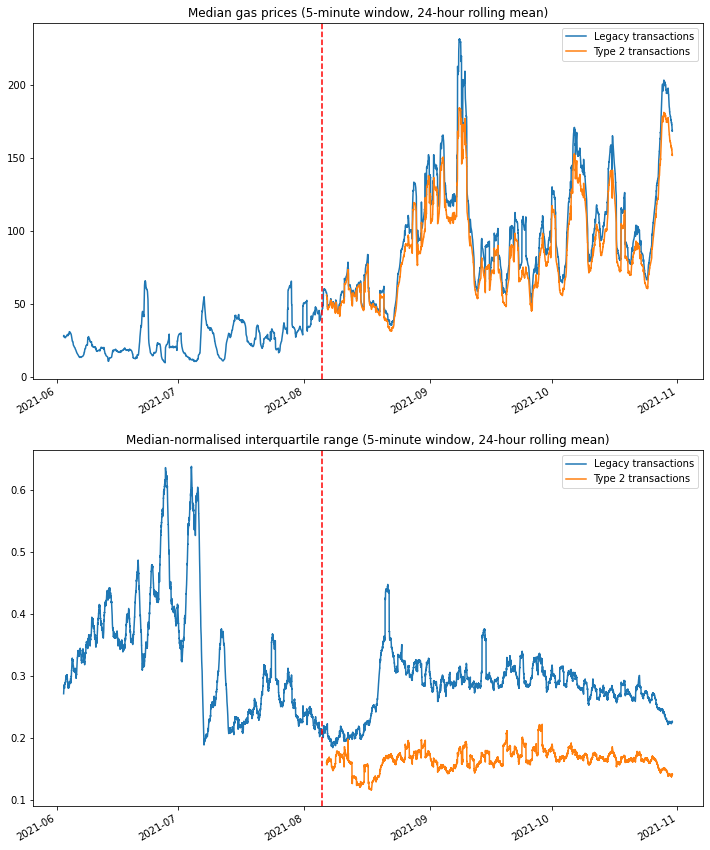

In [11]:
fig, ax = plt.subplots(2, figsize=(12, 16))
x = group_start_times
series_legacy = [list(i) for i in zip(*group_price_quartiles_legacy)]
series_type2 = [list(i) for i in zip(*group_price_quartiles_type2)]

df_legacy = pd.DataFrame({
    '1st quartile':series_legacy[0],
    'median':      series_legacy[1],
    '3rd quartile':series_legacy[2]
}, index=x)
df_legacy['median'].rolling(288).mean().plot(ax=ax[0], label="Legacy transactions")
norm_range_legacy = (df_legacy['3rd quartile'] - df_legacy['1st quartile']) / df_legacy['median']
norm_range_legacy.rolling(288).mean().plot(ax=ax[1], label="Legacy transactions")

df_type2 = pd.DataFrame({
    '1st quartile':series_type2[0],
    'median':    series_type2[1],
    '3rd quartile':series_type2[2]
}, index=x)
df_type2['median'].rolling(288).mean().plot(ax=ax[0], label='Type 2 transactions')
norm_range_type2 = (df_type2['3rd quartile'] - df_type2['1st quartile']) / df_type2['median']
norm_range_type2.rolling(288).mean().plot(ax=ax[1], label='Type 2 transactions')

ax[0].axvline(london_datetime, color='r', linestyle='dashed')
ax[0].set_title("Median gas prices (5-minute window, 24-hour rolling mean)")
ax[0].legend()
ax[1].axvline(london_datetime, color='r', linestyle='dashed')
ax[1].set_title("Median-normalised interquartile range (5-minute window, 24-hour rolling mean)")
ax[1].legend();

In [9]:
with open('tornadocash_transactions.json') as f:
    t = json.load(f)

In [14]:
tornado_transactions = sorted(t['data'], key=lambda k: (k['blockNumber'], k['transactionIndex']))
group_datetime = df_legacy.index.tolist()

tx_datetime = []
tx_price = []
tx_price_factor = []
tx_type = []
colour = []
for tx in tornado_transactions:
    if tx['blockNumber'] < START_BLOCKNUM or tx['blockNumber'] > END_BLOCKNUM:
        continue
    ts = tx['timestamp']
    group_index = (ts - first_group) // group_period
    dt = datetime.utcfromtimestamp(ts)
    tx_datetime += [dt]
    price = tx['receipt']['effectiveGasPrice'] / 1e9
    tx_price += [price]
    if tx['maxFeePerGas'] == 0:
        tx_price_factor += [price / df_legacy['median'].iloc[group_index]]
        tx_type += ['legacy']
        colour +=['tab:blue']
    else:
        tx_price_factor += [price / df_type2['median'].iloc[group_index]]
        tx_type += ['type2']
        colour += ['tab:orange']

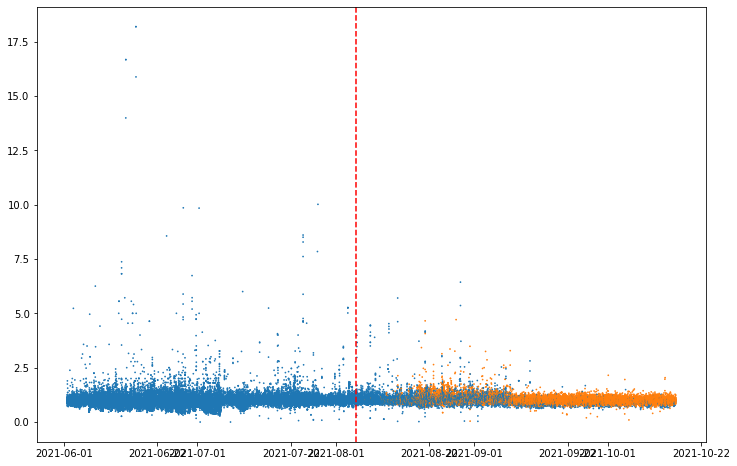

In [15]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(tx_datetime, tx_price_factor, c=colour, s=[0.5] * len(tx_datetime))
ax.axvline(london_datetime, color='r', linestyle='dashed');

In [16]:
num_days = (tx_datetime[-1].date() - tx_datetime[0].date()).days + 1
legacy_sum = [0] * num_days
legacy_sum_sq = [0] * num_days
legacy_count = [0] * num_days
legacy_mean = [None] * num_days
legacy_sigma = [None] * num_days
type2_sum = [0] * num_days
type2_sum_sq = [0] * num_days
type2_count = [0] * num_days
type2_mean = [None] * num_days
type2_sigma = [None] * num_days
mimic_sum = [0] * num_days
mimic_sum_sq = [0] * num_days
mimic_count = [0] * num_days
mimic_mean = [None] * num_days
mimic_sigma = [None] * num_days
for i, factor in enumerate(tx_price_factor):
    day = (tx_datetime[i].date() - tx_datetime[0].date()).days
    if tx_type[i] == 'legacy':
        legacy_sum[day] += factor
        legacy_sum_sq[day] += factor**2
        legacy_count[day] += 1
    elif tx_type[i] == 'type2':
        type2_sum[day] += factor
        type2_sum_sq[day] += factor**2
        type2_count[day] += 1
    else:
        mimic_sum[day] += factor
        mimic_sum_sq[day] += factor**2
        mimic_count[day] += 1

def mean_sigma(sum_x, sum_x2, count):
    mean = sum_x / count
    return mean, math.sqrt((sum_x2 - count * mean**2) / count)
        
for d in range(num_days):
    if legacy_count[d] > 0:
        legacy_mean[d], legacy_sigma[d] = mean_sigma(legacy_sum[d], legacy_sum_sq[d], legacy_count[d])
    if type2_count[d] > 0:
        type2_mean[d], type2_sigma[d] = mean_sigma(type2_sum[d], type2_sum_sq[d], type2_count[d])
    if mimic_count[d] > 0:
        mimic_mean[d], mimic_sigma[d] = mean_sigma(mimic_sum[d], mimic_sum_sq[d], mimic_count[d])

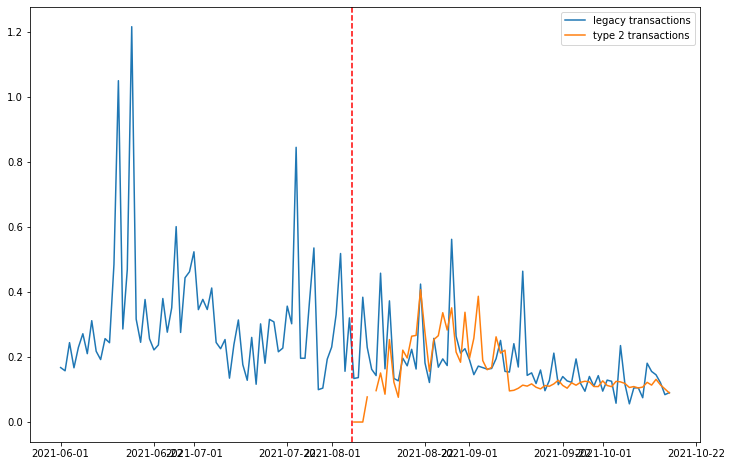

In [18]:
fig, ax = plt.subplots(figsize=(12,8))
x = [tx_datetime[0].date() + timedelta(days=day) for day in range(num_days)]
ax.plot(x, legacy_sigma, label="legacy transactions")
ax.plot(x, type2_sigma, label="type 2 transactions")
ax.axvline(london_datetime, color='r', linestyle='dashed')
ax.legend()